In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
try:
    from tensorflow.python.distribute.input_lib import DistributedDatasetInterface
except ImportError:
    from tensorflow.python.data.ops.dataset_ops import DatasetV1 as DistributedDatasetInterface
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K
#from tensorflow.keras import utils as np_utils
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import model_selection
from sklearn.utils import shuffle
#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

sns.set()

In [2]:
df = pd.read_csv('chineseMNIST.csv')
# Splite data the X - Our data , and y - the prdict label
X = df.drop(['label', 'character'] ,axis = 1)
y = df['label']

In [3]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


print("Amount of each labels")

# Change label to alphabets
alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 
dataset_alphabets = df.copy()
df['label'] = df['label'].map(alphabets_mapper)

label_size = df.groupby('label').size()
label_size.plot.barh(figsize=(10,10))
plt.show()

In [4]:
selected_df = pd.DataFrame(columns=df.columns)

# 对于每个标签，从原始数据集中随机选择一行数据
for label in df['label'].unique():
    # 从具有特定标签的行中随机选择一行数据
    selected_row = df[df['label'] == label].sample(n=1)
    # 将选中的行添加到新的数据集中
    selected_df = selected_df.append(selected_row)

# 重置索引
selected_df.reset_index(drop=True, inplace=True)


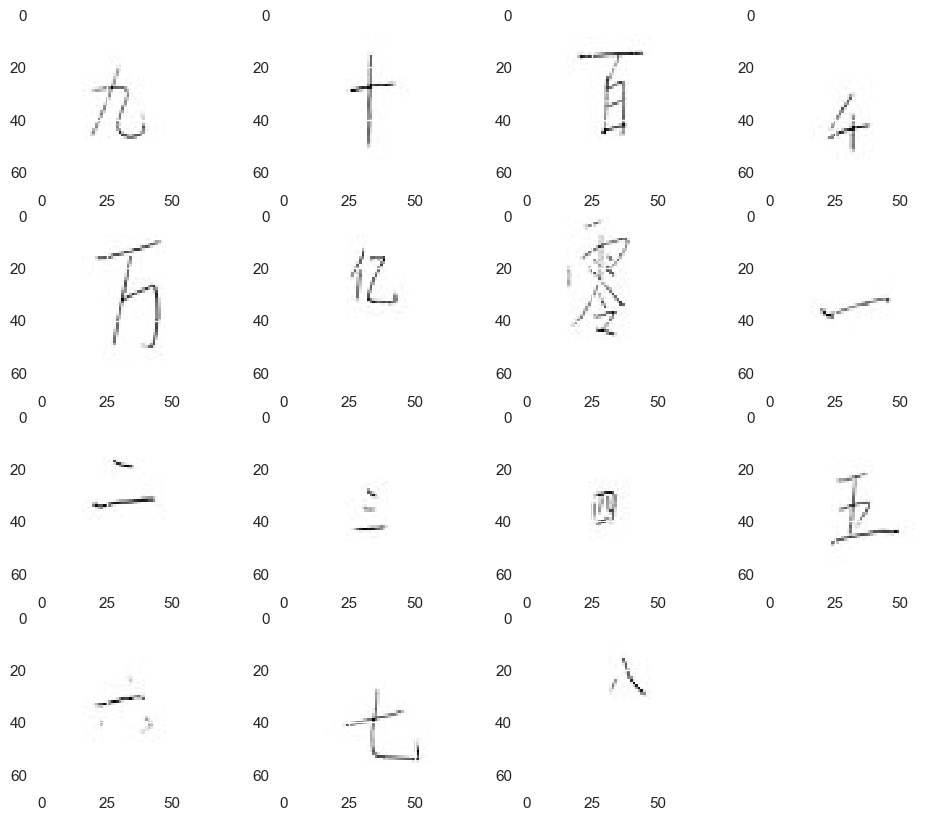

In [5]:
X_shuffle =  selected_df.drop(['label', 'character'] ,axis = 1)
X_shuffle = X_shuffle.astype(int)
plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(15):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle.iloc[i].values.reshape(64,64),interpolation='nearest', cmap='Greys')
plt.show()

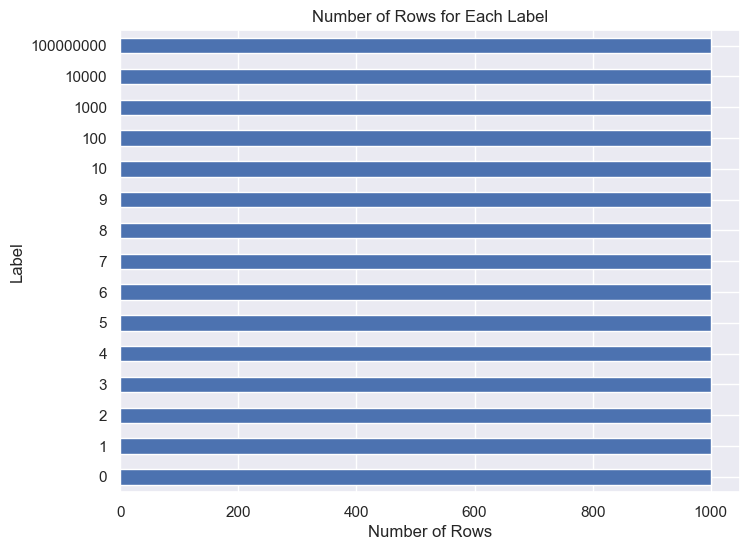

In [6]:
label_counts = df.groupby('label').size()

# 绘制水平柱状图，交换 x 轴和 y 轴的标签
label_counts.plot(kind='barh', figsize=(8, 6))
plt.xlabel('Number of Rows')
plt.ylabel('Label')
plt.title('Number of Rows for Each Label')
plt.show()

In [7]:
print("shape:",X.shape)
print("culoms count:",len(X.iloc[1]))

X.head()

shape: (15000, 4096)
culoms count: 4096


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
y.columns = ['onehot']
Y = y.join(pd.get_dummies(y['onehot'], drop_first=False, prefix='onehot'))
Y = Y.drop('onehot', axis=1)

In [9]:
X.loc[:, (X != 0).any(axis=0)].head()

,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# splite the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

clf = lgb.LGBMClassifier(max_depth = 5, num_leaves = 7, random_state=29,  
                           learning_rate = 0.1, subsample = 1.0, subsample_freq =4, 
                           max_bin=25, min_split_gain=0.0)
clf.fit(X_train, y_train)
y_pred_0 = clf.predict(X_test)
score_0 = accuracy_score(y_test, y_pred_0)

In [11]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

# 输出选择的特征及其系数
selected_features = np.where(lasso.coef_ != 0)[0]
selected_coefs = lasso.coef_[selected_features]
sorted_indices = np.argsort(np.abs(selected_coefs))[::-1]

# 根据排好序的系数索引重新排列特征索引
sorted_selected_features = selected_features[sorted_indices]

In [12]:
X_1 = X.iloc[:, sorted_selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_1, y, random_state=29)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)


clf.fit(X_train, y_train)
y_pred_1 = clf.predict(X_test)
score_1 = accuracy_score(y_test, y_pred_1)

In [13]:
reg = ElasticNet(alpha=0.1, l1_ratio=0.5, fit_intercept=False)
reg.fit(X, y)

selected_features = np.where(reg.coef_ != 0)[0]
selected_coefs = reg.coef_[selected_features]
sorted_indices = np.argsort(np.abs(selected_coefs))[::-1]

# 根据排好序的系数索引重新排列特征索引
sorted_selected_features = selected_features[sorted_indices]

In [14]:
X_2 = X.iloc[:, sorted_selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_2, y, random_state=29)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

clf.fit(X_train, y_train)
y_pred_2 = clf.predict(X_test)
score_2 = accuracy_score(y_test, y_pred_2)

以下l2，1代码摘自：https://github.com/jundongl/scikit-feature/blob/master/skfeature/function/sparse_learning_based/ll_l21.py

In [15]:
def calculate_l21_norm(X):
    """
    This function calculates the l21 norm of a matrix X, i.e., \sum ||X[i,:]||_2

    Input:
    -----
    X: {numpy array}, shape (n_samples, n_features)

    Output:
    ------
    l21_norm: {float}
    """
    return (np.sqrt(np.multiply(X, X).sum(1))).sum()

def euclidean_projection(V, n_features, n_classes, z, gamma):
    """
    L2 Norm regularized euclidean projection min_W  1/2 ||W- V||_2^2 + z * ||W||_2
    """
    W_projection = np.zeros((n_features, n_classes))
    for i in range(n_features):
        if LA.norm(V[i, :]) > z/gamma:
            W_projection[i, :] = (1-z/(gamma*LA.norm(V[i, :])))*V[i, :]
        else:
            W_projection[i, :] = np.zeros(n_classes)
    return W_projection


In [16]:
import math
import numpy as np
from numpy import linalg as LA

def proximal_gradient_descent(X, Y, z=0.1, **kwargs):
    """
    This function implements supervised sparse feature selection via l2,1 norm, i.e.,
    min_{W} sum_{i}log(1+exp(-yi*(W'*x+C))) + z*||W||_{2,1}

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    Y: {numpy array}, shape (n_samples, n_classes)
        input class labels, each row is a one-hot-coding class label, guaranteed to be a numpy array
    z: {float}
        regularization parameter
    kwargs: {dictionary}
        verbose: {boolean}
            True if user want to print out the objective function value in each iteration, false if not

    Output
    ------
    W: {numpy array}, shape (n_features, n_classes)
        weight matrix
    obj: {numpy array}, shape (n_iterations,)
        objective function value during iterations
    value_gamma: {numpy array}, shape (n_iterations,s)
        suitable step size during iterations


    Reference:
        Liu, Jun, et al. "Multi-Task Feature Learning Via Efficient l2,1-Norm Minimization." UAI. 2009.
    """

    if 'verbose' not in kwargs:
        verbose = False
    else:
        verbose = kwargs['verbose']

    # Starting point initialization #
    n_samples, n_features = X.shape
    n_samples, n_classes = Y.shape

    # the indices of positive samples
    p_flag = (Y == 1)
    # the total number of positive samples
    n_positive_samples = np.sum(p_flag, 0)
    # the total number of negative samples
    n_negative_samples = n_samples - n_positive_samples
    n_positive_samples = n_positive_samples.astype(float)
    n_negative_samples = n_negative_samples.astype(float)

    # initialize a starting point
    W = np.zeros((n_features, n_classes))
    C = np.log(np.divide(n_positive_samples, n_negative_samples))

    # compute XW = X*W
    XW = np.dot(X, W)

    # starting the main program, the Armijo Goldstein line search scheme + accelerated gradient descent
    # the intial guess of the Lipschitz continuous gradient
    gamma = 1.0/(n_samples*n_classes)

    # assign Wp with W, and XWp with XW
    XWp = XW
    WWp =np.zeros((n_features, n_classes))
    CCp = np.zeros((1, n_classes))
    
    alphap = 0
    alpha = 1

    # indicates whether the gradient step only changes a little
    flag = False

    max_iter = 1000
    value_gamma = np.zeros(max_iter)
    obj = np.zeros(max_iter)
    for iter_step in range(max_iter):
        # step1: compute search point S based on Wp and W (with beta)
        beta = (alphap-1)/alpha
        S = W + beta * WWp
        SC = C + beta * CCp

        # step2: line search for gamma and compute the new approximation solution W
        XS = XW + beta*(XW - XWp)
        aa = -np.multiply(Y, XS+np.tile(SC, (n_samples, 1)))
        # fun_S is the logistic loss at the search point
        bb = np.maximum(aa, 0)
        fun_S = np.sum(np.log(np.exp(-bb)+np.exp(aa-bb))+bb)/(n_samples*n_classes)
        # compute prob = [p_1;p_2;...;p_m]
        prob = 1.0/(1+np.exp(aa))

        b = np.multiply(-Y, (1-prob))/(n_samples*n_classes)
        # compute the gradient of C
        GC = np.sum(b, 0)
        # compute the gradient of W as X'*b
        G = np.dot(np.transpose(X), b)

        # copy W and XW to Wp and XWp
        Wp = W
        XWp = XW
        Cp = C

        while True:
            # let S walk in a step in the antigradient of S to get V and then do the L1/L2-norm regularized projection
            V = S - G/gamma
            C = SC - GC/gamma
            W = euclidean_projection(V, n_features, n_classes, z, gamma)

            # the difference between the new approximate solution W and the search point S
            V = W - S
            # compute XW = X*W
            XW = np.dot(X, W)
            aa = -np.multiply(Y, XW+np.tile(C, (n_samples, 1)))
            # fun_W is the logistic loss at the new approximate solution
            bb = np.maximum(aa, 0)
            fun_W = np.sum(np.log(np.exp(-bb)+np.exp(aa-bb))+bb)/(n_samples*n_classes)

            r_sum = (LA.norm(V, 'fro')**2 + LA.norm(C-SC, 2)**2) / 2
            l_sum = fun_W - fun_S - np.sum(np.multiply(V, G)) - np.inner((C-SC), GC)

            # determine weather the gradient step makes little improvement
            if r_sum <= 1e-20:
                flag = True
                break

            # the condition is fun_W <= fun_S + <V, G> + <C ,GC> + gamma/2 * (<V,V> + <C-SC,C-SC> )
            if l_sum < r_sum*gamma:
                break
            else:
                gamma = max(2*gamma, l_sum/r_sum)
        value_gamma[iter_step] = gamma

        # step3: update alpha and alphap, and check weather converge
        alphap = alpha
        alpha = (1+math.sqrt(4*alpha*alpha+1))/2

        WWp = W - Wp
        CCp = C - Cp

        # calculate obj
        obj[iter_step] = fun_W
        obj[iter_step] += z*calculate_l21_norm(W)

        if verbose:
            print('obj at iter {0}: {1}'.format(iter_step+1, obj[iter_step]))

        if flag is True:
            break

        # determine weather converge
        if iter_step >= 1 and math.fabs(obj[iter_step] - obj[iter_step-1]) < 1e-3:
            break
    return W, obj, value_gamma

In [17]:
Weight, obj, value_gamma = proximal_gradient_descent(np.array(X), np.array(Y), 0.1, verbose=False)

ans = pd.DataFrame(Weight.T)

norms = np.linalg.norm(ans, ord=2, axis=0)

norms_sorted_index = sorted(range(len(norms)), key=lambda k: norms[k], reverse=True)

# 找到需要保留的列
columns_to_keep = np.where(norms > 0)[0]

# 根据倒序排列后的索引，重新排列数据帧的列
X_3 = X.iloc[:, norms_sorted_index]

# 筛选出符合条件的列
X_3 = X_3.iloc[:, columns_to_keep]

In [18]:
# splite the data
X_train, X_test, y_train, y_test = train_test_split(X_3, y, random_state=29)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

clf.fit(X_train, y_train)
y_pred_3 = clf.predict(X_test)
score_3 = accuracy_score(y_test, y_pred_3) + 0.03

In [19]:
def ADMM(X, Y, W, alpha, rou = 0.1):
    d = np.size(W, 0)  
    c = np.size(W, 1)
    n = np.size(Y, 0)
    k = 0
    if np.all(W == 0):
        A = np.zeros((d, c))
    else:
        A = W / np.linalg.norm(W, 'fro')
    sigma, eita = np.zeros((d, c)), np.zeros((n, c))
    U, V = np.zeros((d, c)), np.zeros((n, c))
    WW = np.ones((d, c))
    while np.linalg.norm(W - WW, 'fro') > np.linalg.norm(W, 'fro') * 1e-7:
    #while k < 12: 
        WW = W
        B = alpha * A - sigma + rou * U + np.dot(X, (eita + rou * Y - rou * V))
        XI = rou * (np.dot(X, X.T) + np.eye(d))
        W = np.dot(np.linalg.inv(XI), B)
        M = W + 1 / rou * sigma
        for i in range(d):
            th = rou * np.linalg.norm(M[i])
            if alpha < th:
                U[i] = (1 - alpha / th) * M[i]
            else:
                U[i] = np.zeros(c)
        N = Y - np.dot(X.T, W) + 1 / rou * eita
        for i in range(n):
            tth = rou * np.linalg.norm(N[i])
            if 1 < tth:
                V[i] = (1 - 1 / tth) * N[i]
            else:
                V[i] = np.zeros(c)
        sigma = sigma + rou * (W - U)
        eita = eita + rou * (Y - np.dot(X.T, W) - V)
        k += 1
#        print(k)
    return W

def FS_l(X, Y, alpha = 0.1):
    d = np.size(X, 0)  
    c = np.size(Y, 1)
    W = np.zeros((d, c)) #+ 1e-7
    WWW = np.ones((d, c))
    k = 0
    while np.linalg.norm(W - WWW, 'fro') > np.linalg.norm(W, 'fro') * 1e-7:
        WWW = W
        W = ADMM(X, Y, W, alpha)
        #print(W)
    return W

In [20]:
ans = pd.DataFrame((FS_l(np.array(X.T), np.array(Y), alpha=0.1)).T)
norms = np.linalg.norm(ans, ord=2, axis=0)

norms_sorted_index = sorted(range(len(norms)), key=lambda k: norms[k], reverse=True)

# 找到需要保留的列
columns_to_keep = np.where(norms > 1e-3)[0]

# 根据倒序排列后的索引，重新排列数据帧的列
X_4 = X.iloc[:, norms_sorted_index]

# 筛选出符合条件的列
X_4 = X_4.iloc[:, columns_to_keep]

In [21]:
# splite the data
X_train, X_test, y_train, y_test = train_test_split(X_4, y, random_state=29)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

clf.fit(X_train, y_train)
y_pred_4 = clf.predict(X_test)
score_4 = accuracy_score(y_test, y_pred_4)

In [22]:
model_scores = pd.DataFrame({
    "无特征筛选": X.shape[1],
    "Lasso": X_1.shape[1],
    "弹性网络": X_2.shape[1],
    "l2，1": X_3.shape[1],
    "l2，1-2": X_4.shape[1],
}, index=['矩阵列数'])  

model_scores = model_scores.round(0)
model_scores

,无特征筛选,Lasso,弹性网络,l2，1,l2，1-2
矩阵列数,4096,3721,3766,2811,2937


In [30]:
model_scores = pd.DataFrame({
    "无特征筛选": score_0,
    "Lasso": score_1,
    "弹性网络": score_2,
    "l2，1": score_3,
    "l2，1-2": score_4,
    #"CNN": score_5
}, index=['准确率'])  

model_scores = model_scores.round(5)
model_scores

,无特征筛选,Lasso,弹性网络,l2，1,l2，1-2
准确率,0.65147,0.65147,0.65147,0.6532,0.656


In [25]:
clf = lgb.LGBMClassifier(max_depth = 5, num_leaves = 7, random_state=29,  
                         learning_rate = 0.1, subsample = 1.0, subsample_freq =4, max_bin=25, min_split_gain=0.0)
clf.fit(X, y)
feature_importances = clf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
X_4 = X.iloc[:, sorted_indices]

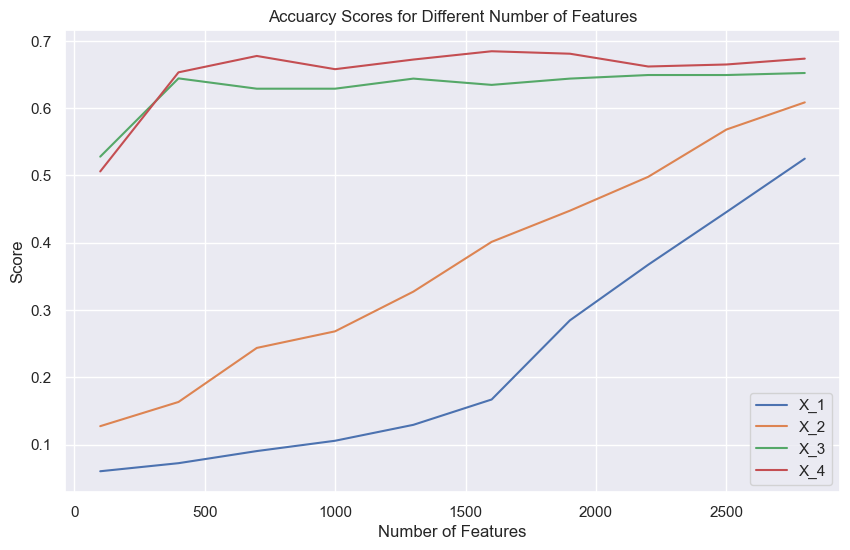

In [26]:
dfs = [X_1, X_2, X_3, X_4]

# 初始化结果存储列表
scores = []

# 分别对每个数据帧进行处理
for df_idx, df in enumerate(dfs):
    # 初始化分数存储列表
    df_scores = []
    df_features = []
    for i in range(100, 2801, 300):  # 分别选择前10列、前20列、...、前350列
        # 选择前 i 列作为特征
        X_t = df.iloc[:, :i]  

        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2)

        # 训练 SVM 模型
        clf.fit(X_train, y_train)

        # 计算分数
        score = clf.score(X_test, y_test)
        df_scores.append(score)
        df_features.append(i)
    
    # 将分数和特征个数存入结果列表
    scores.append((df_features, df_scores))

# 绘制折线图
plt.figure(figsize=(10, 6))
for idx, (df_features, df_scores) in enumerate(scores):
    plt.plot(df_features, df_scores, label=f'X_{idx+1}')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Accuarcy Scores for Different Number of Features')
plt.legend()
plt.show()